# Credit Card Fraud Detection

## The Data   

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.   
Can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

## The goal of the Project

For this project, we'll use everything we've learned about Data Science and Machine Learning thus far to source a dataset, preprocess and explore it, and then build and interpret a classification model that answers your chosen question.

Our goal is to predict if a transaction was fraudulent or not.

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# display options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# date
from datetime import datetime 

# visualizations libraries
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import functions
%load_ext autoreload
%autoreload 2

In [2]:
# ML libraries
import itertools
from collections import Counter
from sklearn.datasets import make_classification
from numpy import where

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.metrics import precision_score, recall_score,confusion_matrix, classification_report, accuracy_score, f1_score  # Skearns Metrics
from sklearn.neighbors import KNeighborsClassifier # KNN Classifier
from xgboost import XGBClassifier # Boosting Algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc # Comparing Various Classifiers
from sklearn.tree import DecisionTreeClassifier

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [3]:
df = pd.read_csv('creditcard.csv')

## Preview the data

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split to train and test sets (not normalised data)

In [5]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

In [6]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data Shapes:")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}")

Data Shapes:
X_train: (199364, 30) | X_test: (85443, 30) | y_train (199364,) | y_test (85443,)


In [8]:
print(f"Number of Frauds in Train Set: {y_train.sum()}")
print(f"Number of Frauds in Test Set: {y_test.sum()}")

Number of Frauds in Train Set: 356
Number of Frauds in Test Set: 136


## Split the train set to train and validation sets

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | y_train {y_train.shape} | y_val {y_val.shape}")

X_train: (139554, 30) | X_val: (59810, 30) | y_train (139554,) | y_val (59810,)


In [10]:
print(f"Number of Frauds in Train: {y_train.sum()}")
print(f"Number of Frauds in Validation: {y_val.sum()}")

Number of Frauds in Train: 258
Number of Frauds in Validation: 98


In [11]:
# Training set
print(y_train.value_counts())
print('\n')
# Validation set
print(y_val.value_counts())

0    139296
1       258
Name: Class, dtype: int64


0    59712
1       98
Name: Class, dtype: int64


## Create a baseline (non normalised data)

For a baseline model do a Logistic Regression model

Recall: [0.99981578 0.63265306]
Precision: [0.99939736 0.84931507]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.85      0.63      0.73        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59701    11]
 [   36    62]]

 Accuracy Percentage  is : 99.92141782310651%


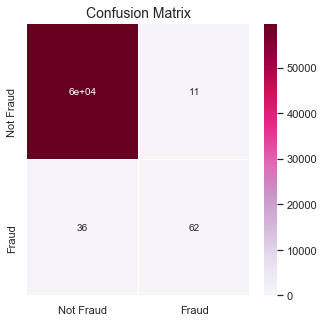

In [12]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
functions.scores(y_val,y_pred);

In [13]:
# distribution of amounts by label
print(df.groupby('Class').agg({'Amount': ['median', 'mean', 'max']}))

      Amount                      
      median        mean       max
Class                             
0      22.00   88.291022  25691.16
1       9.25  122.211321   2125.87


## Scaling

As the data description says, all our features have been PCA transformed except 'Time' and 'Amount'. So we are scaling only these two columns:

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
df.Amount = scaler.fit_transform((df.Amount).values.reshape(-1,1))
df.Time = scaler.fit_transform((df.Time).values.reshape(-1,1))

In [16]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## SMOTE

I'm going to use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.   

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [18]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, y_train = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train).value_counts()) 

0    139296
1       258
Name: Class, dtype: int64


1    139296
0    139296
dtype: int64


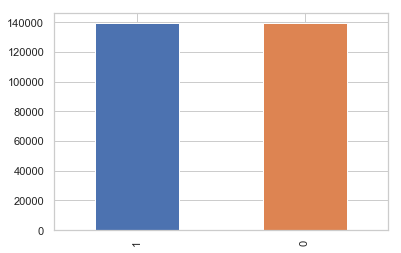

In [19]:
# observe that data has been balanced
pd.Series(y_train).value_counts().plot.bar()

Accuracy = (TP+TN)/total  
Precision = TP/(TP+FP)  
Recall = TP/(TP+FN)  

## Logistic Regression

Recall: [0.98643489 0.85714286]
Precision: [0.99976237 0.09395973]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      0.99      0.99     59712
          1       0.09      0.86      0.17        98

avg / total       1.00      0.99      0.99     59810


 confussion matrix:
 [[58902   810]
 [   14    84]]

 Accuracy Percentage  is : 98.62230396254806%


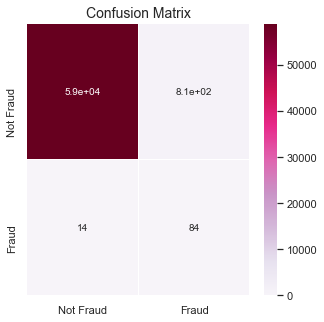

In [20]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
functions.scores(y_val,y_pred);

## KNN

Recall: [0.93190648 0.47959184]
Precision: [0.99908433 0.01142718]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      0.93      0.96     59712
          1       0.01      0.48      0.02        98

avg / total       1.00      0.93      0.96     59810


 confussion matrix:
 [[55646  4066]
 [   51    47]]

 Accuracy Percentage  is : 93.11653569637186%


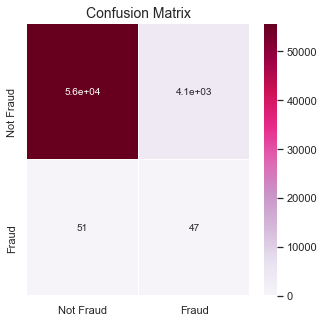

In [21]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_val)
functions.scores(y_val,y_pred);

Recall: [0.94381364 0.54081633]
Precision: [0.99920216 0.01555164]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      0.94      0.97     59712
          1       0.02      0.54      0.03        98

avg / total       1.00      0.94      0.97     59810


 confussion matrix:
 [[56357  3355]
 [   45    53]]

 Accuracy Percentage  is : 94.31533188430028%


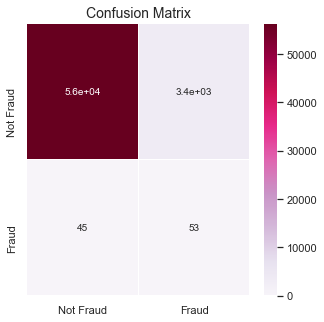

In [22]:
# NN = 3
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_val)
functions.scores(y_val,y_pred);

Recall: [0.92388465 0.48979592]
Precision: [0.99909448 0.01045069]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      0.92      0.96     59712
          1       0.01      0.49      0.02        98

avg / total       1.00      0.92      0.96     59810


 confussion matrix:
 [[55167  4545]
 [   50    48]]

 Accuracy Percentage  is : 92.31733823775289%


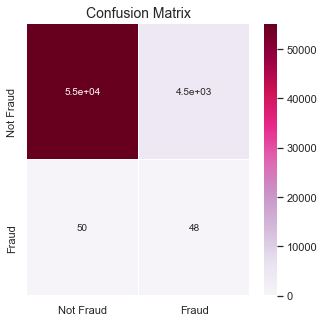

In [23]:
# NN = 7
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_val)
functions.scores(y_val,y_pred);

### I need numpy array

In [24]:
print(type(X_train))
print(type(X_val))
print(type(y_train))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [25]:
X_val = X_val.values
y_val = y_val.values
print(type(X_val))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## XGBoost

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Recall: [0.99792337 0.85714286]
Precision: [0.99976511 0.40384615]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.40      0.86      0.55        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59588   124]
 [   14    84]]

 Accuracy Percentage  is : 99.769269352951%


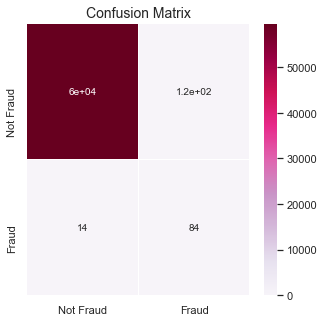

In [26]:
xgb = XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
functions.scores(y_val,y_pred);

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Recall: [0.99946409 0.84693878]
Precision: [0.99974872 0.72173913]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.72      0.85      0.78        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59680    32]
 [   15    83]]

 Accuracy Percentage  is : 99.92141782310651%


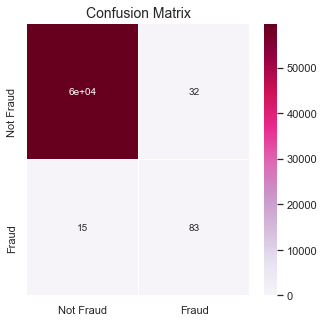

In [27]:
xgb = XGBClassifier(max_depth=15, n_jobs=-1)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
functions.scores(y_val,y_pred);

## Decision Tree

Recall: [0.99768891 0.78571429]
Precision: [0.99964762 0.35813953]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.36      0.79      0.49        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59574   138]
 [   21    77]]

 Accuracy Percentage  is : 99.73415816753052%


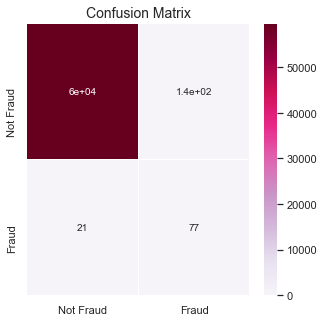

In [28]:
d_tree = DecisionTreeClassifier(random_state=10)  
d_tree.fit(X_train, y_train) 

y_pred = d_tree.predict(X_val)
functions.scores(y_val,y_pred);

## Random Forest Classifier

Recall: [0.99978229 0.81632653]
Precision: [0.99969858 0.86021505]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.86      0.82      0.84        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59699    13]
 [   18    80]]

 Accuracy Percentage  is : 99.9481692024745%


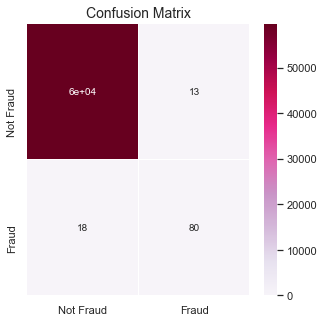

In [29]:
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

y_pred = r_for.predict(X_val)
functions.scores(y_val,y_pred);

In [100]:
p_1, r_1, thresholds_1 = precision_recall_curve(y_val, r_for.predict_proba(X_val)[:,1])

In [101]:
p_1 = list(p_1[:-1])
r_1 = list(r_1[:-1])

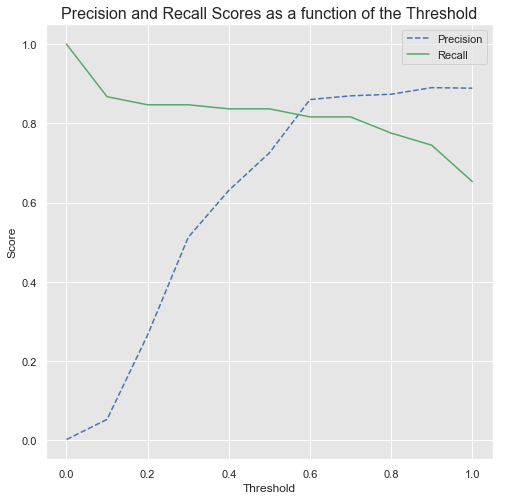

In [102]:
plot_precision_recall_vs_threshold(p_1, r_1, thresholds_1)

AUC: 0.9080544094647506


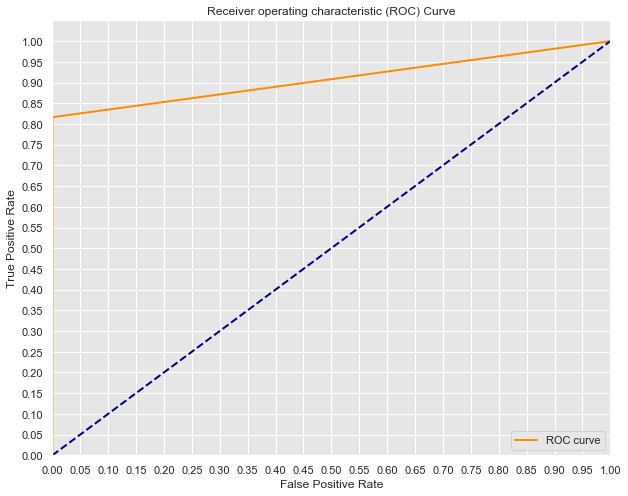

In [87]:
# Initial Model on Validation
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

# Probability scores for test set
y_pred = r_for.predict(X_val)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Threshold Selection

In [30]:
prevalence = df['Class'].sum()/df.shape[0]
fraud_cost_coef = 122.21132113821139
normal_cost_coef = 88.29102242231328

In [43]:
def threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y, y_hat):
    """Calculate the optimal treshold depending on prevalence, costs, true positive rate and false positive rate
    Args:
        prevalence (float): The percentage of positives in the population
        CostFP_minus_CostTN (float): [description]
        CostFN_minus_CostTP (float): [description]
        y (list): True labels (classes)
        y_hat (list): Predicted labels (classes)
    Returns:
        [float]: Best threshold
    """
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
    fm_thresholds = []
    for i in range(len(fpr)):
        fm = tpr[i] - (m * fpr[i])
        fm_thresholds.append((thresholds[i], fm))
    fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
    return fm_thresholds[0][0]

In [60]:
y_prob = r_for.predict_proba(X_val)

In [65]:
set(list(y_prob_adj))

{0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0}

In [46]:
threshold_opt=threshold_selection(prevalence, fraud_cost_coef, normal_cost_coef, y_val, y_prob[:,1])
threshold_opt

0.7

In [80]:
def y_threshed_adj(y_prob, threshold_opt):
    y_prob_adj = y_prob[:,1]
    y_prob_adj_new = []
    for y in y_prob_adj: 
        if y <= (1-threshold_opt):
            y=0
            y_prob_adj_new.append(y)
        else:
            y=1
            y_prob_adj_new.append(y)
    return y_prob_adj_new

In [76]:
confusion_matrix(y_val, y_prob_adj_new)

array([[59664,    48],
       [   16,    82]])

Recall: [0.99919614 0.83673469]
Precision: [0.9997319  0.63076923]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     59712
          1       0.63      0.84      0.72        98

avg / total       1.00      1.00      1.00     59810


 confussion matrix:
 [[59664    48]
 [   16    82]]

 Accuracy Percentage  is : 99.89299448252801%


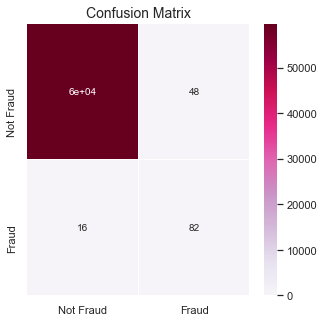

In [77]:
functions.scores(y_val,y_prob_adj_new);

AUC: 0.9336594162674741


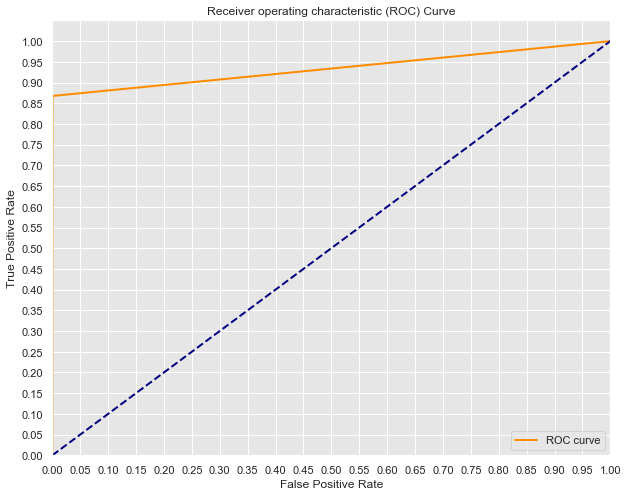

In [85]:
# Initial Model
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

# Probability scores for test set
y_pred = r_for.predict(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Support Vector Machines (SVM)

In [ ]:
# svc = SVC(kernel='linear')
# svc.fit(X_train, y_train)

In [ ]:
# y_pred = svc.predict(X_val)
# functions.scores(y_val,y_pred);

## Final Model

Random Forest Model has the best results so far: 81 TN, 17 FN, 18 FP

Recall: [0.99967177 0.86764706]
Precision: [0.99978897 0.80821918]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     85307
          1       0.81      0.87      0.84       136

avg / total       1.00      1.00      1.00     85443


 confussion matrix:
 [[85279    28]
 [   18   118]]

 Accuracy Percentage  is : 99.94616293903537%


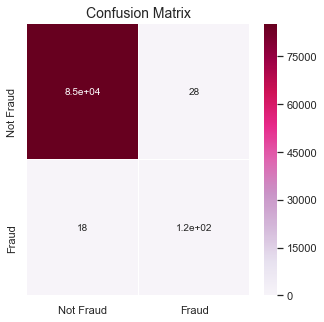

In [78]:
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

y_pred = r_for.predict(X_test)
functions.scores(y_test,y_pred);

In [81]:
y_prob_adj_final = y_threshed_adj(r_for.predict_proba(X_test), threshold_opt)

Recall: [0.99926149 0.89705882]
Precision: [0.99983579 0.65945946]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     85307
          1       0.66      0.90      0.76       136

avg / total       1.00      1.00      1.00     85443


 confussion matrix:
 [[85244    63]
 [   14   122]]

 Accuracy Percentage  is : 99.9098814414288%


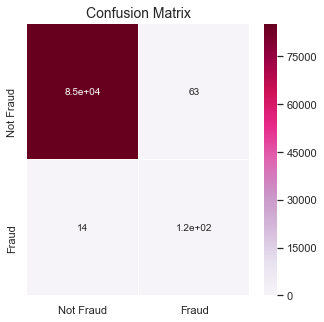

In [82]:
functions.scores(y_test,y_prob_adj_final);

In [89]:
fpr_f, tpr_f, thresholds = roc_curve(y_test, y_prob_adj_final)

In [90]:
thresholds

array([2, 1, 0])

AUC: 0.9619213546367825


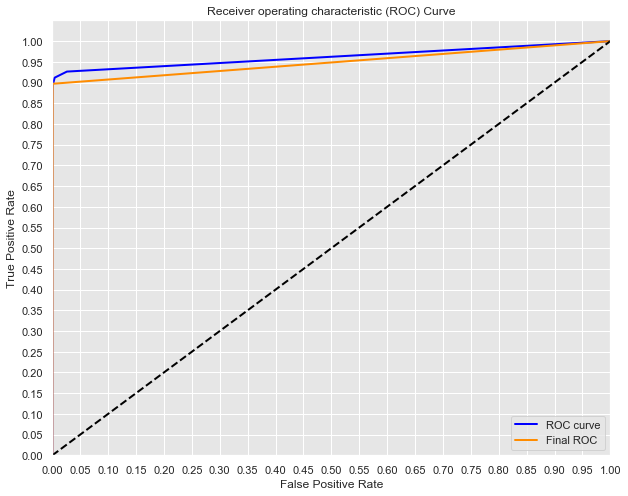

In [92]:
# Initial Model with Threshold = 0.7
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

# Probability scores for test set
y_prob_adj_final = y_threshed_adj(r_for.predict_proba(X_test), threshold_opt)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, (r_for.predict_proba(X_test)[:,1]))
fpr_f, tpr_f, thresholds_f = roc_curve(y_test, y_prob_adj_final)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve')
plt.plot(fpr_f, tpr_f, color='darkorange',
         lw=lw, label='Final ROC')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [93]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the Threshold", fontsize=16)
    plt.plot(thresholds, precisions, "b--", label="Precision")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')

In [94]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_val, y_prob[:,1])

In [95]:
p = list(p[:-1])
r = list(r[:-1])

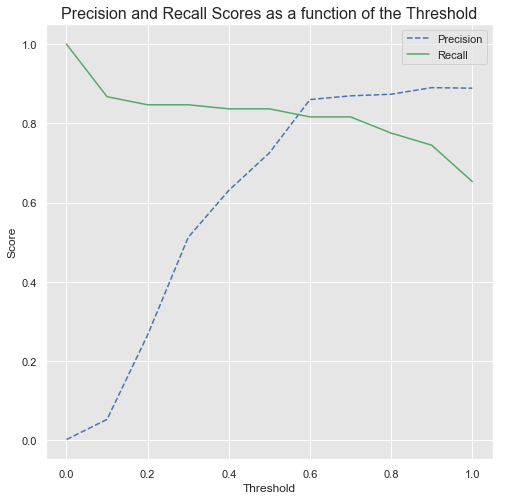

In [96]:
plot_precision_recall_vs_threshold(p, r, thresholds)